Importing Dependencies

In [53]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import cv2
import tensorflow as tf
import imageio

from typing import List

Checking GPU availability and setting GPU

In [54]:
tf.config.list_physical_devices('GPU')

[]

In [55]:
GPU_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(GPU_devices[0], True)
except:
    pass

Data Loading Function

In [56]:
import gdown

In [7]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
data = 'dataset.zip'
gdown.download(url, data, quiet=False)
gdown.extractall('dataset.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=bb1710e7-ec64-4c87-9609-3b385261fe86
To: C:\Users\Suzanne James\OneDrive\Documents\LipRead\dataset.zip
100%|██████████| 423M/423M [00:32<00:00, 12.9MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [57]:
def load_video(path:str) -> List[float]: 

    capture = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = capture.read()

        # rgb to grayscale, so that less data to preprocess
        frame = tf.image.rgb_to_grayscale(frame)
        
        frames.append(frame[190:236,80:220,:])
    capture.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [58]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

Reference : https://keras.io/examples/audio/ctc_asr/

Check the above reference under the preprocess section to know about keras string lookup function

In [59]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [60]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [61]:
char_to_num(['k','e','v','i','n'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([11,  5, 22,  9, 14], dtype=int64)>

In [62]:
num_to_char([11,  5, 22,  9, 14])


<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'k', b'e', b'v', b'i', b'n'], dtype=object)>

Load Alignments function

In [63]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

Load Data function to simultaniously load the video and alignment function 

In [64]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

Grabbing a test data so that we can send and test it in Load Data function

In [65]:
test_path = '.\\data\\s1\\bbaf2n.mpg'

In [66]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbaf2n'

In [67]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

To view a single frame

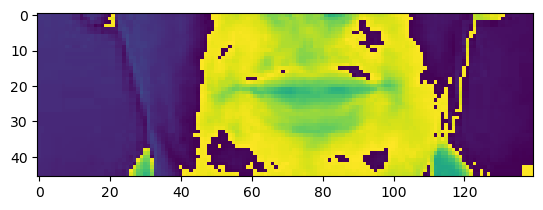

In [68]:
plt.imshow(frames[40])

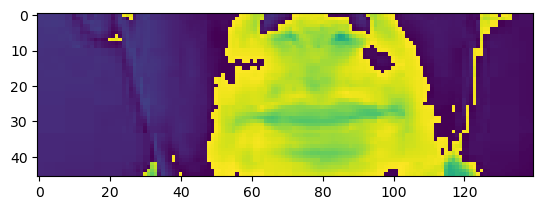

In [69]:
plt.imshow(frames[0])

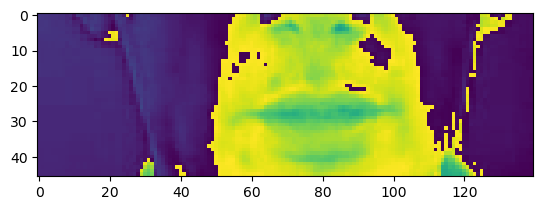

In [70]:
plt.imshow(frames[15])

In [71]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23], dtype=int64)>

In [72]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

Wrapping everything on a tf.py_function mappable function

In [73]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Data Pipeline

In [74]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)

""" here we are creating a batch of 2 videos and 2 alignments
    we are not going to pad shapes our videos,
    but we are going to pad shapes the alignment 40 tokens
    if the 2 set of alignment has less the 40 tokens, the rest will be padded to zero"""
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

# Added for split 
train = data.take(450)
test = data.skip(450)

In [75]:
len(test)

50

In [76]:
frames, alignments = data.as_numpy_iterator().next()

In [77]:
# will display how make frames are there
# expected output : 2 frames
len(frames)

2

In [78]:
sample = data.as_numpy_iterator()

In [79]:
val = sample.next(); val[0]

array([[[[[1.3236979 ],
          [1.3236979 ],
          [1.3236979 ],
          ...,
          [0.31145832],
          [0.3893229 ],
          [0.3503906 ]],

         [[1.3236979 ],
          [1.3236979 ],
          [1.3236979 ],
          ...,
          [0.27252603],
          [0.3893229 ],
          [0.3503906 ]],

         [[1.2847656 ],
          [1.2847656 ],
          [1.2847656 ],
          ...,
          [0.23359375],
          [0.23359375],
          [0.23359375]],

         ...,

         [[0.934375  ],
          [0.934375  ],
          [0.934375  ],
          ...,
          [0.5839844 ],
          [0.4282552 ],
          [0.62291664]],

         [[0.89544266],
          [0.89544266],
          [0.89544266],
          ...,
          [0.54505205],
          [0.5061198 ],
          [0.5839844 ]],

         [[0.89544266],
          [0.89544266],
          [0.89544266],
          ...,
          [0.5061198 ],
          [0.5839844 ],
          [0.5839844 ]]],


        [[[1.3236

creating an GIF video

In [80]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to 

Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.927734375]. Convert image to 

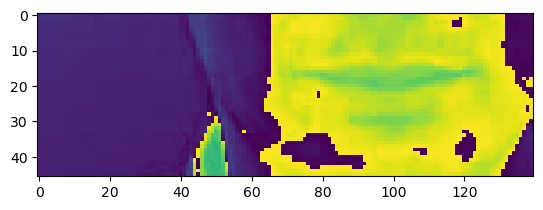

In [81]:
"""  
0: videos,
0: 1st video out of the batch,  
0: return the first frame in the video 
"""

plt.imshow(val[0][0][0])

In [82]:
tf.strings.reduce_join([num_to_char(word) for word in val[0][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaiiiiiiiiiiiiiiiiiiiiihhhhhhhhhhhhhhhhhhhhhhiiiiiiiiiiiiiiiiiiiiiiiaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaabaaaaaaiiiiiiiiiiiiiiiiiiiiiihhhhhhhhhhhhhhhhhhhhhiiiiiiiiiiiiiiiiiiiiiiaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaiiiiiiiiiiiiiiiiiiiiiihhhhhhhhhhhhhhhhhhhhhiiiiiiiiiiiiiiiiiiiiaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaiiiiiiiiiiiiiiiiiiiiiihhhhhhhhhhhhhhhhhhhhhiiiiiiiiiiiiiiiiiiiiaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaiiiiiiiiiiiiiiiiiiiiiihhhhhhhhhhhhhhhhhhhhiiiiiiiiiiiiiiiiiiiiiiiiaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaiiiiiiiiiiiiiiiiiiiiihhhhhhhhhhhhhhhhhiiihiiiiiiiiiiiiiiiiiiiiiiiiaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaiiiiiiiiiiiiiiiiiiihhhhhhhhhhhhhhhhhhhiihhhiiiiiiiiiiiiiiiiiiiiiiiaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaiiiiiiiiiiiiiiiiiihhhhhhhiihhhhhhhhhhhiihhhiiiihhiiiiiiiiiiiiiiiiiaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

## 3. Building a Deep Learning model

In [83]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [84]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

What they have used in the LipNet paper, we have tried to replicate something similar to it

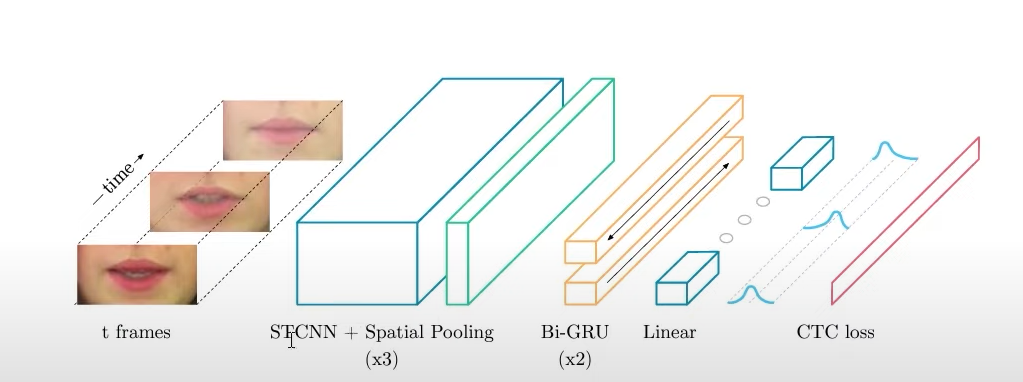

In [85]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))


In [86]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [87]:
5*17*75

6375

In [88]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [89]:
yhat

array([[[0.01998101, 0.03788577, 0.02298315, ..., 0.02391334,
         0.02180803, 0.02937687],
        [0.02003271, 0.03907236, 0.02220131, ..., 0.0239392 ,
         0.02131073, 0.02910415],
        [0.01983282, 0.03930216, 0.02141167, ..., 0.02387382,
         0.02091477, 0.02877529],
        ...,
        [0.02000054, 0.02443978, 0.01781054, ..., 0.02469621,
         0.02879421, 0.02197656],
        [0.02039056, 0.02300851, 0.01857473, ..., 0.02459019,
         0.02904958, 0.02152636],
        [0.020597  , 0.02156953, 0.01977337, ..., 0.0248649 ,
         0.02909667, 0.02110238]],

       [[0.02075138, 0.03659232, 0.02475077, ..., 0.02485315,
         0.02220575, 0.02751802],
        [0.02057327, 0.03769601, 0.02373526, ..., 0.02500172,
         0.02170555, 0.02692401],
        [0.02034072, 0.03788979, 0.02275494, ..., 0.02501027,
         0.02145893, 0.02642079],
        ...,
        [0.02149023, 0.02192252, 0.01738743, ..., 0.02486351,
         0.03005773, 0.02246758],
        [0.0

In [90]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'aaaaaaaooooooooooooooooxxxxxwwwwwwwwwwwwwwwwwwwwwwwwwxxxxwwwwwwwwwxxxxxxwww'>

In [91]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'aaaaaaaooooooooooooooooxxxxxwwwwwwwwwwwwwwwwwwwwwwwwwxxxxwwwwwwwwwxxxxxxwww'>

In [92]:
model.input_shape

(None, 75, 46, 140, 1)

In [93]:
model.output_shape

(None, 75, 41)

# 4. Training

In [94]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

Reference : https://keras.io/examples/audio/ctc_asr/

Check the above reference under the Model >>> CTC loss function

In [95]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [96]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [97]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [98]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [99]:
schedule_callback = LearningRateScheduler(scheduler)

In [100]:
example_callback = ProduceExample(test)

In [52]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  2/450 [..............................] - ETA: 5:46:14 - loss: 203.3430

KeyboardInterrupt: 

# 5. Prediction Phase

In [101]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=1a377fce-0abd-478a-a4e6-0ddd3e88961b
To: C:\Users\Suzanne James\OneDrive\Documents\LipRead\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:07<00:00, 12.6MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [102]:
model.load_weights('models/checkpoint')

In [103]:
test_data = test.as_numpy_iterator()

In [104]:
sample = test_data.next()

In [105]:
yhat = model.predict(sample[0])

1/1 [==============================] - 3s 3s/step


Actual sentence

In [106]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green with d zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green at f five soon'>]

In [107]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

Predicted sentence

In [108]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green with d zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay green at f five soon'>]

# 6. Testing Phase

In [109]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\lbbk6p.mpg'))

Actual Sentence

In [110]:
print('~'*30, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by k six please'>]

In [111]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [112]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [113]:
print('~'*30, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay blue by k six please'>]